In [541]:
import numpy as np
import math
import os
import random
from matplotlib import pyplot as plt
import queue

PAGE_SIZE = 4096                    # Page Size in Bytes
NP = 6                              # No. of processes in memory
F = 16                              # No. of Frames in physical memory
INVALID = -10
PID = 0                             # Used for Indexing into Frames
FRAME = 1                           # Used for Indexing into Frames
COMPLETED = 10                      # Process Status Flags
INCOMPLETE = 20                     #
# The following are page replacement algorithm types
FIFO_GLOBAL = 10
oldest_frame = 0
loc_oldest_frame = np.zeros(F).astype('int32')
pr_status = np.full(NP, INCOMPLETE).astype('int32')

In [542]:
class Node:
    def __init__(self,pid=None,pagenum=None):
        self.pid=pid
        self.pagenum=pagenum
        self.nextval=None
        
        
class LinkedList:
    def __init__(self):
        self.headval=None
    
    def printlist(self):
        printval=self.headval
        while printval is not None:
            print([printval.pid,printval.pagenum])
            printval=printval.nextval
            
    def atBegining(self,pid,pagenum):
        newNode=Node(pid,pagenum)
        if self.headval is None:
            self.headval=newNode
            return
        newNode.nextval=self.headval
        self.headval=newNode
        
    def atLast(self,pid,pagenum):
        newNode=Node(pid,pagenum)
        if self.headval is None:
            self.headval=newNode
            return
        currentval=self.headval
        while currentval.nextval is not None:
            currentval=currentval.nextval
        currentval.nextval=newNode

In [543]:
phys_mem=LinkedList()

In [544]:
def init_proc_queue() :
    pq = queue.Queue(maxsize=NP)
    proc_queue = list(set((NP * np.random.random(20)).astype('int32')))
    random.shuffle(proc_queue)
    print(proc_queue)
    for pr in proc_queue:
        pq.put_nowait(pr)
    return(pq)

In [545]:
def sim_process(M, sigma, outfile, lfrac=0.9) :
    cur_page = int(M * np.random.random())  # Generate a random start page
    cur_locale = round(PAGE_SIZE * (cur_page + 0.5))  #Locality of reference
    sum_refs = 0
    list_locales = list()
    for count in range(M) :
        num_refs = int(512 + (PAGE_SIZE - 512) * np.random.random()) # random page address in memory.
        sum_refs += num_refs
        list_locales.append(cur_page)
        num_loc = round(lfrac * num_refs)
        aref_list = np.random.normal(cur_locale, sigma * 300 + 100,
                                    num_loc)   #If siagma is less, it stays less within that locality of reference
        #if sigma more, it may vary more
        aref_list = correct_refs(aref_list, cur_locale, M)
        aref_list = aref_list.astype('int32')
        cur_page = int(M * np.random.random())
        cur_locale = round(PAGE_SIZE * (cur_page + 0.5))
        num_trans = round((1 - lfrac) * num_refs)
        tref_list = np.random.random(num_trans) * cur_locale
        tref_list = correct_refs(tref_list, 0, M)
        tref_list = tref_list.astype('int32')
        np.append(aref_list, tref_list).tofile(outfile, sep='\n')
        outfile.write('\n')
    
    return list_locales, sum_refs

def correct_refs(alist, cent, maxpg) :
    if cent != 0 :
        pgnum = int(cent / PAGE_SIZE)
        lh = (pgnum + 1) * PAGE_SIZE - 1
        ll = pgnum * PAGE_SIZE
    else :
        lh = maxpg * PAGE_SIZE
        ll = 0
    for i in range(alist.shape[0]) :
        if alist[i] >= lh :
            alist[i] = lh - 1
        if alist[i] < ll :
            alist[i] = ll + 1
    return alist

In [546]:
def init_phys_mem() :
    for i in range(F):
        phys_mem.atBegining(INVALID,INVALID)
        
def update_phys_mem(pid) :
    temp=phys_mem.headval
    while temp is not None:
        if temp.pid==pid:
            temp.pid=INVALID
            temp.pagenum=INVALID
        temp=temp.nextval


In [547]:
def mem_manager(infile, outfile, pid) :
#    num_faults = 0
    # Read a number of address references, i.e., execute the process
    # partially (or fully, if the number generated is > process size)
    num_addr = 512 + int(4096 * np.random.random())
    idx = 0
    while idx < num_addr :
        addr_ref = infile.readline().strip()
        if addr_ref == '' :
            break
        addr_ref = int(addr_ref)
        pg_num = int(addr_ref / PAGE_SIZE)
        pg_offset = addr_ref % PAGE_SIZE
        pg_base, pg_fault = get_pageframe(pg_num, pid)
#        if pg_fault == 2 :
#            print(f'Page replaced for Process {pid} at frame: {pg_base/PAGE_SIZE}')
        if  pg_base >= 0 :
            phys_addr = pg_base + pg_offset
            outfile.write(str(addr_ref) + ',' + str(phys_addr) + ','
                          + str(pg_fault) + '\n')
            if pg_fault == 0 :
                pr_timing[pid] += IN_MEMORY
            elif pg_fault == 1 :
                pr_timing[pid] += MEM_FAULT
            else :
                pr_timing[pid] += PAGE_REPLACE
        else :
            print(idx)
            return INVALID
        idx += 1
        
    if idx >= num_addr :    
        return INCOMPLETE
    return COMPLETED

def get_pageframe(pnum, pr) :
    fr_num = 0
    temp=phys_mem.headval
    is_present=False
    while fr_num<F and temp.nextval is not None:
#         print(fr_num)
        previous=temp
        if temp.pid==pr and temp.pagenum==pnum:
            is_present=True
#             print("!st if",temp.pid,temp.pagenum)
            phys_mem.headval=temp.nextval
            break
        elif temp.nextval.pid==pr and temp.nextval.pagenum==pnum:
            is_present=True
#             print("2nd if",temp.nextval.pid,temp.nextval.pagenum)
            previous.nextval=temp.nextval.nextval
            fr_num+=1
            break
        else:
            fr_num+=1
        temp=temp.nextval
    if is_present:
        while temp.nextval is not None:
            temp=temp.nextval
        temp.nextval=Node(pid=pr,pagenum=pnum)
        return fr_num * PAGE_SIZE, 0
    else:
        fr_num = gen_pagefault(pnum, pr)
        if fr_num >= 0 :
            return fr_num * PAGE_SIZE, 1
    
        fr_num = page_replace(pnum, pr)
        
        if fr_num >= 0 :
            return fr_num * PAGE_SIZE, 2
    
    return INVALID, 0

def gen_pagefault(pgnum, pr) :
    fr_num = 0
    temp=phys_mem.headval
    while fr_num<F and temp is not None and temp.pagenum>=0:
        fr_num+=1
        temp=temp.nextval
    
    if fr_num>=F:
        return INVALID
    temp.pid=pr
    temp.pagenum=pgnum
    return fr_num


def page_replace(pgnum, pr):
    node=Node(pid=pr,pagenum=pgnum)
    temp=phys_mem.headval
    phys_mem.headval=temp.nextval
    while temp.nextval is not None:
        temp=temp.nextval
    temp.nextval=node
    return F-1


def print_phys_mem() :
    temp=phys_mem.headval
    i=0
    print('{:^10s} {:^6s} {:^6s}'.format('Frame', 'PID', 'Page No.'))
    print('{:^10s} {:^6s} {:^6s}'.format('-----', '---', '--------'))
    while i<F and temp.nextval is not None:
        if temp.pid != INVALID :
            print('{:^10d} {:^6d} {:^6d}'.format(i, temp.pid,temp.pagenum))
        else:
            print('Free Frame: ', i)
        i+=1
            
def readq(q):
    while True:
        try:
            yield q.get_nowait()
        except queue.Empty:
            break

In [548]:
pr_size = np.zeros(NP, dtype='int32')
for p in range(NP) :
    fname = 'AR_' + '{:02d}'.format(p) + '.txt'
    op = open(fname, 'w')
    npg = int(np.random.normal(10,2.5))
    nsig = int(5 * np.random.random())
    print(f'Process {p} requires {npg} pages and has a quality {nsig}')
    pg_seq, pr_size[p] = sim_process(npg, nsig, op)
    print(pg_seq, pr_size[p])
    op.write('\n')
    op.close()
    print('Written process ', p, 'to ', fname)

Process 0 requires 7 pages and has a quality 0
[3, 3, 4, 5, 3, 3, 2] 17858
Written process  0 to  AR_00.txt
Process 1 requires 10 pages and has a quality 4
[1, 9, 0, 7, 6, 0, 8, 0, 5, 1] 20399
Written process  1 to  AR_01.txt
Process 2 requires 8 pages and has a quality 2
[4, 1, 1, 7, 1, 4, 3, 5] 19249
Written process  2 to  AR_02.txt
Process 3 requires 8 pages and has a quality 3
[3, 3, 4, 2, 7, 4, 4, 1] 17412
Written process  3 to  AR_03.txt
Process 4 requires 9 pages and has a quality 1
[1, 1, 3, 2, 5, 0, 2, 2, 5] 24505
Written process  4 to  AR_04.txt
Process 5 requires 13 pages and has a quality 2
[0, 1, 0, 6, 7, 5, 3, 12, 12, 4, 0, 0, 0] 32170
Written process  5 to  AR_05.txt


In [549]:
# We assume that Process Simulator(s) has(ve) been run earlier.
# Otherwise do so now! Or else memory manager will fail gracefully?

# Initialise Physical Memory and Process Queue
init_phys_mem()
oldest_frame = 0
pr_que = init_proc_queue()
pr_timing = np.zeros(F).astype('int32')
IN_MEMORY = 1
MEM_FAULT = 50
PAGE_REPLACE = 100

# Open necessary files
infiles = list()
outfiles = list()
for i in range(NP) :
    fname = 'AR_{:02d}.txt'.format(i)
    outname = 'AR_{:02}_out.txt'.format(i)
    if os.access(fname, os.R_OK) :
        print(f'Reading Process from {fname}')
        infiles.append(open(fname, 'r'))
    else:
        print(f'Cannot open {fname} for reading')
    outfiles.append(open(outname, 'w'))

# Map logical into physical addresses and keep track of page faults
for pr in readq(pr_que) :
    rv = mem_manager(infiles[pr], outfiles[pr], pr)
    if rv == INVALID :
        print('Memory overflow error')
        break
    if rv == INCOMPLETE :
        pr_que.put_nowait(pr)
    else :
#         print(f'Process {pr} (Size: {pr_size[pr]} Bytes) completed; \
#         removing from queue')
#         print(f'Time taken: {pr_timing[pr]}')
#         slow = (pr_timing[pr] - pr_size[pr]) * 100.0 / pr_size[pr]
#         print('Slow down by {:.2f}%'.format(slow))
#         print_phys_mem()
        update_phys_mem(pr)
#        print('Current Status of Physical Memory')
        

# Close all files
for i in range(NP) :
    infiles[i].close()
    outfiles[i].close()
    
# Print the Pages in Physical Memory
# print_phys_mem()

[3, 5, 0, 2, 1, 4]
Reading Process from AR_00.txt
Reading Process from AR_01.txt
Reading Process from AR_02.txt
Reading Process from AR_03.txt
Reading Process from AR_04.txt
Reading Process from AR_05.txt


In [550]:
import seaborn as sns
from collections import Counter
file=open('AR_00_out.txt','r')
data=file.read()
datas=np.array(data.split('\n'))
faults=[data[-1] for data in datas[:-1]]

c:\users\rissu\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

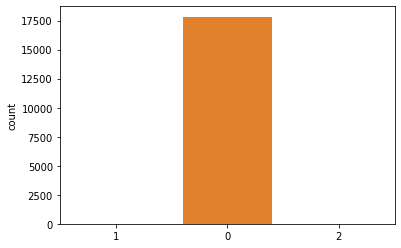

In [551]:
sns.countplot(faults)


In [552]:
Counter(faults)

Counter({'1': 1, '0': 17832, '2': 25})